In [144]:
# Importing the required libraries:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2
import skimage

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import platform
print(torch.__version__)
print(platform.python_version())

1.1.0
3.6.10


In [145]:
torch.cuda.get_device_name(0)

'TITAN X (Pascal)'

In [146]:
train_set = ['hola', 'urjc', 'gavab', 'estoril', 'alvaro', 'victoria', 'jose', 'fuengirola'] * 512
val_set = ['hola', 'urjc', 'gavab', 'estoril', 'alvaro', 'victoria', 'jose', 'fuengirola'] * 64
test_set = ['estoril', 'fuengirola']

MAX_LENGTH = max(len(list(word)) for word in train_set)

len_train = len(train_set)
len_val = len(val_set)

In [147]:
# Function to convert letters (and therefore words) into PyTorch tensors:

letters = ['SOS_token', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
          'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'EOS_token']

PAD_token = torch.zeros(1, 1, 28)

def letter_to_vector(letter):
    vector = torch.zeros(1, 1, len(letters))
    for i in range(len(letters)):
        if letters[i] == letter:
            vector[0, 0, i] = 1.
    return(vector)

print(PAD_token)
print(letter_to_vector('SOS_token'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]]])
tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [148]:
def patch_gen(word, n_patches, patch_height, patch_width, stepsize):
    
    image = 255 * np.ones(shape = [height, width], dtype = np.uint8)
    image = cv2.putText(image, text = word, org = (5, 30),
    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, color = (0, 0, 0),
    thickness = 2, lineType = cv2.LINE_AA)
    image = transforms.ToPILImage()(image) # np.ndarray to PIL.Image.Image
    patches_tensor = torch.empty(n_patches, 1, patch_height, patch_width)
    
    for p in range(n_patches):
        
        patch = transforms.functional.crop(image, 0, 0 + p * stepsize, patch_height, patch_width) # cropping of the image into patches
        patch = transforms.ToTensor()(patch) # torch.Tensor of the patch (normalized)
        #patch = skimage.util.random_noise(patch, mode='gaussian') # we set some random noise to the image
        #patch = torch.from_numpy(patch) # conversion to pytorch tensor again
        patch = 1. - patch # it will work better if we have white text over black background
        patch = patch.view(1, 1, patch_height, patch_width) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
        patch = patch.type(torch.FloatTensor) # conversion to float
        patch = patch.cuda() # set to cuda
        patches_tensor[p, 0, :, :] = patch
        patches_tensor = patches_tensor.cuda()
        
    return patches_tensor

In [149]:
# Setting image and sliding window parameters:

height = 48
width = 192
patch_height = 48
patch_width = 10
stepsize = 2
color_channels = 1
n_patches = int((width - patch_width)/stepsize + 1)

In [150]:
# Defining function to get a tuple for each image with (its 92 tensor patches, label):

def complete_set(set):
    complete_set = []
    for word in set:
        complete_set.append((patch_gen(word, n_patches, patch_height, patch_width, stepsize), word))
        
    return complete_set

In [151]:
comp_train_set = complete_set(set = train_set)
comp_val_set = complete_set(set = val_set)
comp_test_set = complete_set(set = test_set)

In [152]:
# Loading data in image batches:

batch_size = 2

train_loader = DataLoader(comp_train_set, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(comp_val_set, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(comp_test_set, batch_size = batch_size, shuffle=False)


for image, label in train_loader:
    break
    
image_cnn = image.view(-1, color_channels, patch_height, patch_width)   
print(image.shape)
print(image_cnn.shape)
print(label)

torch.Size([2, 92, 1, 48, 10])
torch.Size([184, 1, 48, 10])
('jose', 'victoria')


In [153]:
def get_one_hot_target(label):
    
    one_hot_target = torch.zeros(batch_size, MAX_LENGTH + 1, output_size) # one_hot_tensor of the input batch of words for Decoder
    
    for j in range(batch_size): # for each word of the batch
        
        length = len(list(label[j])) # compute the number of letters
        
        one_hot_target[j, 0, :] = letter_to_vector('SOS_token') # the first letter of every word is always the SOS_token
        
        for k in range(length): # for each letter
            
            one_hot_target[j, k + 1, :] = letter_to_vector(list(label[j])[k]) # add the one_hot vector of that letter
                                                                              # to the global tensor
    return one_hot_target        

In [154]:
# Defining model and architecture:

# CONVOLUTIONAL NEURAL NETWORK:

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1, 2) # padding???
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 2)
        self.fc1 = nn.Linear(12*2*50, 1024)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 12*2*50) # -1 para no tener que determinar aquí el tamaño del batch (se ajusta, podemos variarlo)
        X = F.relu(self.fc1(X))

        return X 

In [155]:
# ENCODER:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)

    def forward(self, input, hidden):
        
        output = input.view(batch_size, n_patches, input_size)
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

In [156]:
# DECODER:

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(output_size, hidden_size, batch_first = True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2) 
        # dim = 2 porque esta última dimensión es la correspondiente a output_size, que es sobre
        # la que queremos hacer el softmax

    def forward(self, input, hidden):
        #output = input.view(batch_size, MAX_LENGTH + 1, output_size)
        output = input
        #output = F.relu(output) # la relu se metía aquí porque en el
        #caso NLP del ejemplo de PyTorch previamente había una capa de embedding
        #No nos hace falta porque nuestro tensor de inputs ya es one-hot
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
               torch.zeros(1, batch_size, self.hidden_size, device=device))

In [158]:
torch.manual_seed(123)

input_size = 1024
hidden_size = 256
output_size = 28

CNN_model = ConvolutionalNetwork().cuda()
CNN_optimizer = torch.optim.Adam(CNN_model.parameters(), lr = 0.001)

Encoder_model = EncoderRNN(input_size = input_size, hidden_size = hidden_size).cuda()
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr = 0.001)

Decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = output_size).cuda()
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr = 0.001)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

In [159]:
# TRAINING THE MODEL:

import time
start_time = time.time()

epochs = 30

train_losses = []
val_losses = []

torch.manual_seed(123)

for i in range(epochs):
    
    for b, (image, label) in enumerate(train_loader):
        
        b += 1
        
        encoder_hidden = Encoder_model.initHidden()
        
        image_cnn = image.view(-1, color_channels, patch_height, patch_width).cuda()
        encoder_input = CNN_model(image_cnn)
        _, encoder_hidden = Encoder_model(encoder_input, encoder_hidden)
        
        decoder_hidden = encoder_hidden
        decoder_input = get_one_hot_target(label=label).cuda()
        decoder_output, decoder_hidden = Decoder_model(decoder_input, decoder_hidden)
        
        output_indices = torch.tensor(list(range(0, MAX_LENGTH))).cuda() # remove EOS_token from the output
        decoder_output = torch.index_select(decoder_output, dim = 1, index = output_indices)
        
        ground_truth = torch.argmax(decoder_input, 2)
        target_indices = torch.tensor(list(range(1, MAX_LENGTH + 1))).cuda() # remove SOS_token from the input
        ground_truth = torch.index_select(ground_truth, dim = 1, index = target_indices)
        #decoder_output = decoder_output.view(batch_size, output_size, MAX_LENGTH)
        
        loss = 0
        
        for j in range(batch_size):
            
            loss += criterion(decoder_output[j], ground_truth[j])   
        #loss = criterion(decoder_output[j], ground_truth[j]) + criterion(decoder_output[1], ground_truth[1])
        
        loss = loss/batch_size
        
        CNN_optimizer.zero_grad()
        Encoder_optimizer.zero_grad()
        Decoder_optimizer.zero_grad()
        
        loss.backward()
        
        CNN_optimizer.step()
        Encoder_optimizer.step()
        Decoder_optimizer.step()
    
    
    with torch.no_grad():
        
        for v, (image_val, label_val) in enumerate(val_loader):
        
            v += 1

            encoder_hidden_val = Encoder_model.initHidden()

            image_cnn_val = image_val.view(-1, color_channels, patch_height, patch_width).cuda()
            encoder_input_val = CNN_model(image_cnn_val)
            _, encoder_hidden_val = Encoder_model(encoder_input_val, encoder_hidden_val)

            decoder_hidden_val = encoder_hidden_val
            decoder_input_val = get_one_hot_target(label=label_val).cuda()
            decoder_output_val, decoder_hidden_val = Decoder_model(decoder_input_val, decoder_hidden_val)

            output_indices_val = torch.tensor(list(range(0, MAX_LENGTH))).cuda() # remove EOS_token from the output
            decoder_output_val = torch.index_select(decoder_output_val, dim = 1, index = output_indices_val)

            ground_truth_val = torch.argmax(decoder_input_val, 2)
            target_indices_val = torch.tensor(list(range(1, MAX_LENGTH + 1))).cuda() # remove SOS_token from the input
            ground_truth_val = torch.index_select(ground_truth_val, dim = 1, index = target_indices_val)
            #decoder_output_val = decoder_output_val.view(batch_size, output_size, MAX_LENGTH)
            
            loss_val = 0
            
            for j in range(batch_size):
                
                loss_val += criterion(decoder_output_val[j], ground_truth_val[j])
            
            #loss_val = criterion(decoder_output_val[0], ground_truth_val[0]) + criterion(decoder_output_val[1], ground_truth_val[1])
            loss_val = loss_val/batch_size
        
        
    train_losses.append(loss)
    val_losses.append(loss_val)
    print(i)
    
print(f'Duration: {(time.time() - start_time)/60} minutes')    
print(train_losses)
print(val_losses)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Duration: 10.741639296213785 minutes
[tensor(1.9803, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8501, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.2566, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.3551, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8163, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.8292, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.7231, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.0175, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.9671, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.9338, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.8569, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.1085, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.8065, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.5819, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.5589, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.5567, device='cuda

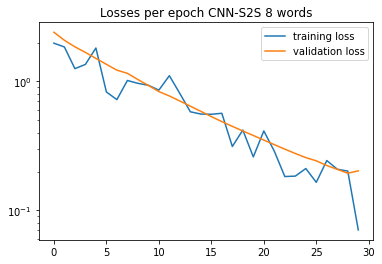

In [160]:
# Plotting results

plt.yscale("log")
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Losses per epoch CNN-S2S 8 words')
plt.legend();
#plt.savefig('8 words training losses lr=0,001, bs=2')

In [61]:
#torch.save(CNN_model.state_dict(), 'CNN_model_8_words_batch.pt')
#torch.save(Encoder_model.state_dict(), 'Encoder_model_8_words_batch.pt')
#torch.save(Decoder_model.state_dict(), 'Decoder_model_8_words_batch.pt')

In [246]:
with torch.no_grad():
        
    for t, (image_test, label_test) in enumerate(test_loader):

        t += 1

        encoder_hidden_test = Encoder_model.initHidden()
        image_cnn_test = image_test.view(-1, color_channels, patch_height, patch_width).cuda()
        encoder_input_test = CNN_model(image_cnn_test)
        encoder_outputs_test, encoder_hidden_test = Encoder_model(encoder_input_test, encoder_hidden_test)
    
        for j in range(batch_size):
           
            decoder_input_test = letter_to_vector('SOS_token').cuda() # We initialize the first Decoder input as the SOS token
            
            decoder_hidden_test = (encoder_hidden_test[0][0, j, :].view(1, 1, hidden_size), # We take the last hidden state of the Encoder 
                                   encoder_hidden_test[1][0, j, :].view(1, 1, hidden_size)) # for each image/word (j) within the patch 
            # This would be the first hidden state of the Decoder for image/word (j)

            for d in range(MAX_LENGTH):
                
                decoder_output_test, decoder_hidden_test = Decoder_model(decoder_input_test, decoder_hidden_test)
                
                if d == 0:
                    
                    output_word = decoder_output_test
                    
                else:
                    
                    output_word = torch.cat((output_word, decoder_output_test), dim = 1).cuda()
                    
            output_word = torch.argmax(output_word, dim = 2)
            
            
            if j == 0:
                
                total_output_word = output_word
                
            else:
                
                total_output_word = torch.cat((total_output_word, output_word), dim = 0)
           
    print(total_output_word)


for j in range(batch_size):
    
    model_word = []
    
    for i in range(total_output_word[j].numel()):
        
        
        model_word.append(letters[total_output_word[j][i]])
        

    #model_word = ''.join(model_word)    
    print(model_word)



torch.Size([1, 10, 28])
torch.Size([1, 10, 28])
tensor([[ 5, 19, 20, 15, 18,  9, 12,  0,  0,  0],
        [ 6, 21,  5, 14,  7,  9, 18, 15, 12,  1]], device='cuda:0')
['e', 's', 't', 'o', 'r', 'i', 'l', 'SOS_token', 'SOS_token', 'SOS_token']
['f', 'u', 'e', 'n', 'g', 'i', 'r', 'o', 'l', 'a']


In [140]:
torch.manual_seed(101)
c = nn.LogSoftmax(dim=1)
a = torch.randn(1,2,3)
print(c(a))
print(a)

tensor([[[-2.2407, -0.3303, -1.2581],
         [-0.1125, -1.2684, -0.3344]]])
tensor([[[-1.3905, -0.8152, -0.3204],
         [ 0.7377, -1.7534,  0.6033]]])


In [91]:
np.log((np.exp(-1.3905))/(np.exp(-1.3905) + np.exp(-0.8152) + np.exp(-0.3204)))

-1.7392961570497802

In [141]:
np.log((np.exp(-1.3905))/(np.exp(-1.3905) + np.exp(0.7377)))

-2.240681356437162

In [221]:
a = torch.ones(28)
c = torch.argmax(a, dim = 0)
print(a)
print(c)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(27)
